In [279]:
!pip install datasets pandas matplotlib seqeval -q


In [280]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json 
from datasets import load_dataset
import seqeval
from seqeval.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score      
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')


# Analyse des classes de MedMention et CONLL2003

## Analyse des données brutes

In [281]:
def plot_class_distribution(dataset_name, label_col='ner_tags', splits=['train', 'validation', 'test'], plot=False):
    """Analyse la distribution des classes pour un dataset NER"""
    try:
        dataset = load_dataset(dataset_name, trust_remote_code=True)
    except Exception as e:
        print(f"Erreur: {e}")
        return

    results = {}
    
    for split in splits:
        if split not in dataset:
            continue
            
        # Extraction des labels
        all_labels = []
        for example in dataset[split]:
            labels = [l for l in example[label_col] if l != -100]
            
            if isinstance(labels[0], int):
                label_names = dataset[split].features[label_col].feature.names
                labels = [label_names[l] for l in labels]
                
            all_labels.extend(labels)

        # Calcul des stats
        counter = Counter(all_labels)
        total = sum(counter.values())
        
        # Création du DataFrame
        df = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
        df['percentage'] = round((df['count']/total)*100, 2)
        df = df.sort_values('percentage', ascending=False)
        
        results[split] = df
        if plot:
            # Plot
            plt.figure(figsize=(12, 5))
            df.head(15).plot(kind='bar', y='percentage', title=f'{dataset_name} - {split}')
            plt.xticks(rotation=45, ha='right')
            plt.ylabel('% of total')
            plt.show()


    return results

In [282]:
conll_stats = plot_class_distribution('conll2003')
conll_stats

{'train':          count  percentage
 O       169578       83.28
 B-LOC     7140        3.51
 B-PER     6600        3.24
 B-ORG     6321        3.10
 I-PER     4528        2.22
 I-ORG     3704        1.82
 B-MISC    3438        1.69
 I-MISC    1155        0.57
 I-LOC     1157        0.57,
 'validation':         count  percentage
 O       42759       83.25
 B-PER    1842        3.59
 B-LOC    1837        3.58
 B-ORG    1341        2.61
 I-PER    1307        2.54
 B-MISC    922        1.80
 I-ORG     751        1.46
 I-MISC    346        0.67
 I-LOC     257        0.50,
 'test':         count  percentage
 O       38323       82.53
 B-LOC    1668        3.59
 B-ORG    1661        3.58
 B-PER    1617        3.48
 I-PER    1156        2.49
 I-ORG     835        1.80
 B-MISC    702        1.51
 I-LOC     257        0.55
 I-MISC    216        0.47}

In [283]:
medmentions_stats = plot_class_distribution('ibm-research/MedMentions-ZS')

In [284]:
# with open('medmentions_stats.txt', 'w') as f:
#     f.write(medmentions_stats.__str__())
medmentions_stats   

{'train':          count  percentage
 O       515420       73.52
 B-T038   25007        3.57
 B-T103   22360        3.19
 I-T038   15708        2.24
 B-T058   14779        2.11
 I-T103   14011        2.00
 B-T017   12575        1.79
 I-T058   12088        1.72
 B-T033    9824        1.40
 B-T082    7511        1.07
 I-T017    7474        1.07
 I-T033    6432        0.92
 B-T170    5996        0.86
 B-T062    5445        0.78
 I-T170    5118        0.73
 B-T204    4922        0.70
 I-T062    4392        0.63
 B-T098    3574        0.51
 I-T082    2998        0.43
 I-T204    2360        0.34
 B-T074    1165        0.17
 I-T074    1030        0.15
 I-T098     881        0.13,
 'validation':         count  percentage
 O       34400       92.23
 I-T092    478        1.28
 B-T092    452        1.21
 B-T037    434        1.16
 B-T201    404        1.08
 I-T201    236        0.63
 B-T005    224        0.60
 I-T037    225        0.60
 B-T091    196        0.53
 I-T091    124        0.33
 I-T005

In [285]:
# nombre de classes 

classes = []
for split in medmentions_stats.keys():
    for index, row in medmentions_stats[split].iterrows():
        classes.append(index)
classes = list(set(classes))
# Strip B and I 
classes = [i[2:] for i in classes if i.startswith('B-') or i.startswith('I-') ]
classes = list(set(classes))
classes.append('O')
classes = list(set(classes))
len(classes)

22

In [286]:
medmentions_stats['train']['count'].sum(), medmentions_stats['validation']['count'].sum(), medmentions_stats['test']['count'].sum()

(701070, 37297, 29783)

In [287]:
conll_stats['train']['count'].sum(), conll_stats['validation']['count'].sum(), conll_stats['test']['count'].sum()

(203621, 51362, 46435)

In [288]:
# 1. Identification des classes manquantes
tui_list = pd.read_csv("umls/tui_list.csv")["tui"]
try:
    dataset = load_dataset('ibm-research/MedMentions-ZS', trust_remote_code=True)
except Exception as e:
    print(f"Erreur: {e}")

split = ['train', 'validation', 'test']
for s in split:
    if s not in dataset:
        continue
    print(f'{s} : {len(dataset[s])}')
        
    # print(dataset['train'][0]['ner_tags'])
    dataset_ner_tags = [dataset[s][i]['ner_tags'] for i in range(len(dataset[s]))]
    dataset_ner_tags = [item for sublist in dataset_ner_tags for item in sublist]
    dataset_tuis = set(dataset_ner_tags)
    # print(f"Nombre de classes dans le dataset : {len(dataset_ner_tags)}")

    missing_tuis = set(tui_list) - dataset_tuis

    if len(missing_tuis) > 0:
        print(f"/!\\ {len(missing_tuis)} TUIs manquants : {sorted(missing_tuis)}")



train : 26770
/!\ 127 TUIs manquants : ['T001', 'T002', 'T004', 'T005', 'T007', 'T008', 'T010', 'T011', 'T012', 'T013', 'T014', 'T015', 'T016', 'T017', 'T018', 'T019', 'T020', 'T021', 'T022', 'T023', 'T024', 'T025', 'T026', 'T028', 'T029', 'T030', 'T031', 'T032', 'T033', 'T034', 'T037', 'T038', 'T039', 'T040', 'T041', 'T042', 'T043', 'T044', 'T045', 'T046', 'T047', 'T048', 'T049', 'T050', 'T051', 'T052', 'T053', 'T054', 'T055', 'T056', 'T057', 'T058', 'T059', 'T060', 'T061', 'T062', 'T063', 'T064', 'T065', 'T066', 'T067', 'T068', 'T069', 'T070', 'T071', 'T072', 'T073', 'T074', 'T075', 'T077', 'T078', 'T079', 'T080', 'T081', 'T082', 'T083', 'T085', 'T086', 'T087', 'T088', 'T089', 'T090', 'T091', 'T092', 'T093', 'T094', 'T095', 'T096', 'T097', 'T098', 'T099', 'T100', 'T101', 'T102', 'T103', 'T104', 'T109', 'T114', 'T116', 'T120', 'T121', 'T122', 'T123', 'T125', 'T126', 'T127', 'T129', 'T130', 'T131', 'T167', 'T168', 'T169', 'T170', 'T171', 'T184', 'T185', 'T190', 'T191', 'T192', 'T194', 

## Équilibrage des données (sur-échantillonage)

In [289]:
# !pip install scikit-multilearn -q
# !pip list

In [290]:
from datasets import load_dataset
from datasets import concatenate_datasets
from skmultilearn.model_selection import IterativeStratification
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from collections import defaultdict

In [291]:

# Charger et combiner les données
try:
    dataset = load_dataset('ibm-research/MedMentions-ZS', trust_remote_code=True)
except Exception as e:
    print(f"Erreur: {e}")
combined = concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])


In [292]:

# Extraire les TUIs
tuis_per_doc = []
for doc in combined: 
    tuis_per_doc.append(set(doc['ner_tags']))
    
print(len(tuis_per_doc))



29107


In [293]:

# Créer le mapping TUI vers indice
all_tuis = list({tui for tuis in tuis_per_doc for tui in tuis})
tui_to_idx = {tui: idx for idx, tui in enumerate(all_tuis)}


In [294]:
from datasets import load_dataset
from datasets import DatasetDict
from skmultilearn.model_selection import IterativeStratification
from skmultilearn.model_selection import iterative_train_test_split
from scipy.sparse import csr_matrix
import numpy as np

def balanced_split(dataset, ratios=[0.8, 0.1, 0.1], seed=42):
    """
    Effectue un split stratifié multi-label selon les ratios spécifiés
    Args:
        dataset: Dataset HuggingFace à splitter (combinée)
        ratios: Liste de 3 proportions [train, val, test] qui doivent sommer à 1
        seed: Seed pour la randomisation
    Returns:
        Tuple de 3 datasets (train, val, test)
    """
    # Validation des paramètres
    dataset_combined = concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])


    np.random.seed(seed)

    assert len(ratios) == 3, "Doit spécifier 3 ratios"
    assert abs(sum(ratios) - 1.0) < 1e-6, "Les ratios doivent sommer à 1"
    
    # Extraire les TUIs
    print("Extraction des NER-Tags...")
    tuis_per_doc = []
    for doc in dataset_combined: 
        tuis_per_doc.append(set(doc['ner_tags']))
    print("Fait!")
    # print(len(tuis_per_doc))

    print("Création du mapping TUI vers indice...")
    # Créer le mapping TUI vers indice
    all_tuis = sorted({tui for tuis in tuis_per_doc for tui in tuis})
    tui_to_idx = {tui: idx for idx, tui in enumerate(all_tuis)}


    num_docs = len(dataset_combined)
    num_tuis = len(all_tuis)
    
    row_indices = []
    col_indices = []
    for doc_idx, tuis in enumerate(tuis_per_doc):
        for tui in tuis:
            row_indices.append(doc_idx)
            col_indices.append(tui_to_idx[tui])

    label_matrix = csr_matrix((np.ones(len(row_indices)), 
                            (row_indices, col_indices)), 
                            shape=(num_docs, num_tuis))

    print("Fait!")

    indices = np.arange(len(dataset_combined))  

    print("Shuffle des indices avant le split...")
    np.random.shuffle(indices)  # Mélange les indices des documents
    label_matrix = label_matrix[indices]  # Applique le même shuffle aux labels
    print("Fait!")

    print("Création du premier split (train VS reste)...")
    # Premier split: train vs temp (val+test)
    train_ratio = ratios[0]
    X_train, Y_train, X_temp, Y_temp = iterative_train_test_split(
        indices.reshape(-1, 1), 
        label_matrix, 
        test_size=1-train_ratio
    )
    
    print("Fait!")
    print("Création du deuxième split (val VS test)...")
    # Deuxième split: val vs test
    val_ratio = ratios[1]/(1 - train_ratio)
    X_val, Y_val, X_test, Y_test = iterative_train_test_split(
        X_temp,
        Y_temp,
        test_size=1-val_ratio
    )
    print("Fait!")

    print("Conversion des indices...")
    # Convertir les indices
    train_indices = np.setdiff1d(indices, X_temp.flatten())
    val_indices = X_val.flatten()
    test_indices = X_test.flatten()
    print("Fait! ")

    # Vérifier les overlaps
    assert len(set(train_indices) & set(val_indices)) == 0, "Overlap entre train et val"
    assert len(set(train_indices) & set(test_indices)) == 0, "Overlap entre train et test"
    assert len(set(val_indices) & set(test_indices)) == 0, "Overlap entre val et test"

    # Vérifier que tous les exemples sont dans au moins un split
    assert len(set(train_indices) | set(val_indices) | set(test_indices)) == len(dataset_combined), "Certains exemples ne sont pas dans un split"

    print("Tous les exemples sont dans un split! et sans overlaps.")
    print("Stratification terminée!")
    return DatasetDict({
        "train": dataset_combined.select(train_indices),
        "validation": dataset_combined.select(val_indices),
        "test": dataset_combined.select(test_indices)
    })

# Charger et combiner les données
try:
    dataset = load_dataset('ibm-research/MedMentions-ZS', trust_remote_code=True)
    print(dataset.keys())
except Exception as e:
    print(f"Erreur: {e}")
# combined = concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])


# Paramètres personnalisables ici
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

new_dataset = balanced_split(
    dataset,
    # ratios=[train_ratio, val_ratio, test_ratio], 
    seed=42
)


dict_keys(['train', 'validation', 'test'])
Extraction des NER-Tags...
Fait!
Création du mapping TUI vers indice...
Fait!
Shuffle des indices avant le split...
Fait!
Création du premier split (train VS reste)...
Fait!
Création du deuxième split (val VS test)...
Fait!
Conversion des indices...
Fait! 
Tous les exemples sont dans un split! et sans overlaps.
Stratification terminée!


In [295]:

train_dataset, val_dataset, test_dataset = new_dataset['train'], new_dataset['validation'], new_dataset['test']


In [296]:
def check_dataset_structure(original_dataset, new_dataset):
    """
    Vérifie que la structure des datasets est identique entre le dataset d'origine et celui produit
    (même colonnes et types de données).
    Args:
        original_dataset: Le dataset d'origine.
        new_dataset: Le dataset retourné (par exemple après stratification).
    """
    # Vérifier que les datasets contiennent les mêmes colonnes
    assert original_dataset.column_names == new_dataset.column_names, "Les colonnes ne correspondent pas !"
    assert original_dataset['train'].features == new_dataset['train'].features, "Les types de données ne correspondent pas !"
    assert original_dataset['train'].column_names == new_dataset['train'].column_names, "Les colonnes ne correspondent pas !"
    assert original_dataset['validation'].features == new_dataset['validation'].features, "Les types de données ne correspondent pas !"
    assert original_dataset['validation'].column_names == new_dataset['validation'].column_names, "Les colonnes ne correspondent pas !"
    assert original_dataset['test'].features == new_dataset['test'].features, "Les types de données ne correspondent pas !"
    assert original_dataset['test'].column_names == new_dataset['test'].column_names, "Les colonnes ne correspondent pas !"
    
    print("La structure des datasets est identique !")


# Vérification de la structure des datasets
check_dataset_structure(dataset, new_dataset)


La structure des datasets est identique !


In [297]:
# TEST DE LA FONCTION balanced_split - On vérifie qu'elle renvoie bien le même dataset avec la même seed, et que le 
# dataset change bien avec la seed, et qu'il a la même structure que le dataset d'origine. 
# new_dataset2 = balanced_split(
#     dataset,
#     # ratios=[train_ratio, val_ratio, test_ratio],
#     seed=42
# )
# train_dataset2, val_dataset2, test_dataset2 = new_dataset2['train'], new_dataset2['validation'], new_dataset2['test']



# new_dataset3 = balanced_split(
#     dataset,
#     # ratios=[train_ratio, val_ratio, test_ratio],
#     seed=65
# )
# train_dataset3, val_dataset3, test_dataset3 = new_dataset3['train'], new_dataset3['validation'], new_dataset3['test']



# # Vérification 
# assert len(train_dataset) == len(train_dataset2), "Les datasets d'entraînement ne sont pas de la même taille"
# assert np.all(train_dataset2['ner_tags'] == train_dataset['ner_tags']), "Les datasets d'entraînement ne sont pas identiques"

# # Changement avec la seed : 50% de différence entre les datasets d'entraînement
# assert len(train_dataset) != len(train_dataset3), "Les datasets d'entraînement sont identiques avec une seed différente"
# assert np.mean(train_dataset3['ner_tags'] == train_dataset['ner_tags']) < 0.5, "Plus de 50% de similarité entre les datasets d'entraînement avec une seed différente"




In [298]:

# Vérification des tailles
print(f"Train: {len(train_dataset)} ({len(train_dataset)/len(combined):.1%})")
print(f"Validation: {len(val_dataset)} ({len(val_dataset)/len(combined):.1%})")
print(f"Test: {len(test_dataset)} ({len(test_dataset)/len(combined):.1%})")

Train: 23273 (80.0%)
Validation: 2954 (10.1%)
Test: 2880 (9.9%)


In [299]:
# Import de counter
from collections import Counter
def get_tui_distribution(dataset):
    """Calculer la distribution des TUIs dans le dataset"""
    tui_counter = Counter()
    for example in dataset:
        tui_counter.update(example['ner_tags'])
    return tui_counter



# Calculer les distributions
train_dist = get_tui_distribution(train_dataset)
val_dist = get_tui_distribution(val_dataset)
test_dist = get_tui_distribution(test_dataset)

In [300]:
# Trier les distributions
train_dist = dict(sorted(train_dist.items(), key=lambda item: item[1], reverse=True))
val_dist = dict(sorted(val_dist.items(), key=lambda item: item[1], reverse=True))
test_dist = dict(sorted(test_dist.items(), key=lambda item: item[1], reverse=True))

# Créer un DataFrame pour la visualisation
train_df = pd.DataFrame(list(train_dist.items()), columns=['TUI', 'CountTrain'])
val_df = pd.DataFrame(list(val_dist.items()), columns=['TUI', 'CountVal'])
test_df = pd.DataFrame(list(test_dist.items()), columns=['TUI', 'CountTest'])
# Fusionner les DataFrames
merged_df = pd.merge(train_df, val_df, on='TUI', how='outer')
merged_df = pd.merge(merged_df, test_df, on='TUI', how='outer')

# Ajouter une colonne pour le pourcentage
merged_df['Total'] = merged_df[['CountTrain', 'CountVal', 'CountTest']].sum(axis=1)
merged_df['PercentageTrain'] = (merged_df['CountTrain'] / merged_df['Total']) * 100
merged_df['PercentageVal'] = (merged_df['CountVal'] / merged_df['Total']) * 100
merged_df['PercentageTest'] = (merged_df['CountTest'] / merged_df['Total']) * 100



In [301]:
# merged_df.to_csv('tui_distribution.csv', index=False)
merged_df

,TUI,CountTrain,CountVal,CountTest,Total,PercentageTrain,PercentageVal,PercentageTest
0,O,463032,57856,56365,577253,80.213009,10.022642,9.764349
1,B-T038,19938,2562,2507,25007,79.729676,10.245131,10.025193
2,B-T103,17991,2177,2192,22360,80.460644,9.736136,9.803220
3,I-T038,12603,1596,1509,15708,80.233002,10.160428,9.606570
4,B-T058,11832,1481,1466,14779,80.059544,10.020976,9.919480
5,I-T103,11201,1426,1384,14011,79.944329,10.177718,9.877953
6,B-T017,10072,1233,1270,12575,80.095427,9.805169,10.099404
7,I-T058,9616,1182,1290,12088,79.549967,9.778293,10.671741
8,B-T033,7860,990,974,9824,80.008143,10.077362,9.914495
9,B-T082,6018,741,752,7511,80.122487,9.865531,10.011982


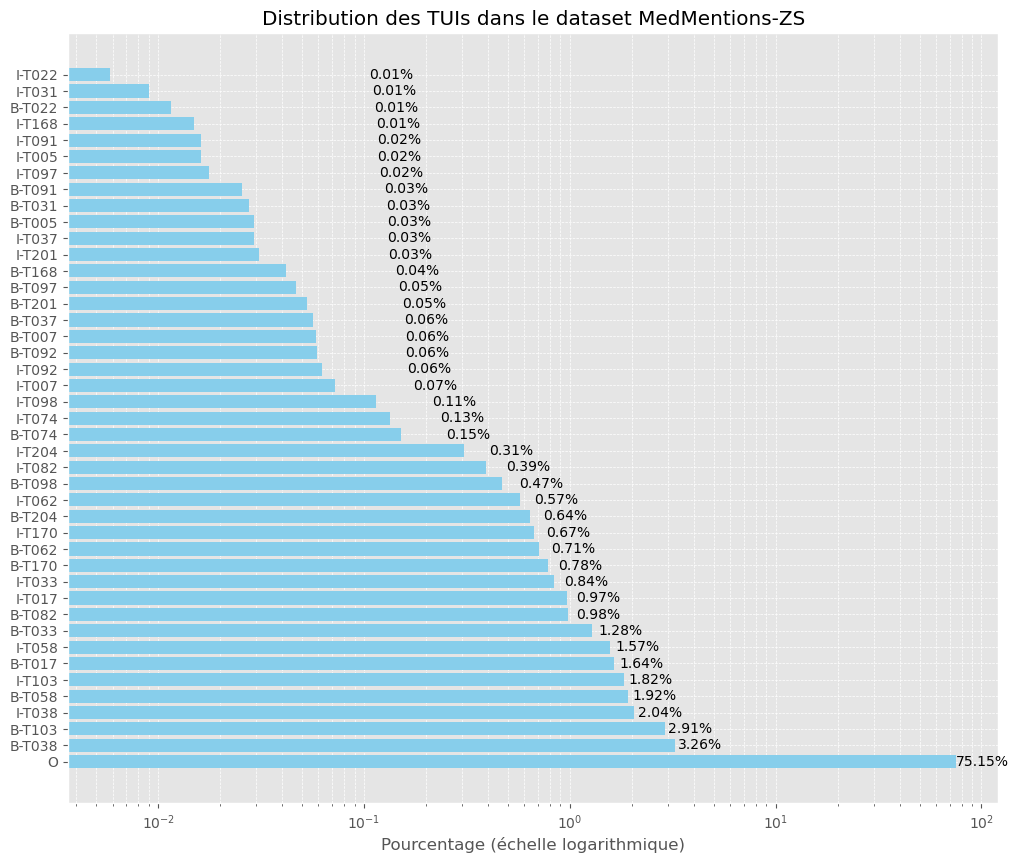

In [302]:
df_total = merged_df[['TUI', 'Total']].copy()
df_total['Percentage'] = (df_total['Total'] / df_total['Total'].sum()) * 100
df_total = df_total.sort_values('Percentage', ascending=False)


fig, ax = plt.subplots(figsize=(12, 10))
ax.barh(df_total['TUI'], df_total['Percentage'], color='skyblue')
ax.set_xscale('log')
ax.set_xlabel('Pourcentage (échelle logarithmique)')
ax.set_title('Distribution des TUIs dans le dataset MedMentions-ZS')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
# Ajout des labels 
for i, v in enumerate(df_total['Percentage']):
    ax.text(v + 0.1, i, f"{v:.2f}%", color='black', va='center')

plt.show()


In [303]:
df_total_class = df_total.copy()
df_total_class['TUI'] = df_total_class['TUI'].str.replace('B-', '').str.replace('I-', '')
df_total_class = df_total_class.groupby('TUI').agg({'Total': 'sum'}).reset_index()
df_total_class['Percentage'] = (df_total_class['Total'] / df_total_class['Total'].sum()) * 100  
df_total_class.sort_values('Percentage', ascending=False)


,TUI,Total,Percentage
0,O,577253,75.148474
8,T038,40715,5.300397
17,T103,36371,4.734883
9,T058,26867,3.497624
3,T017,20049,2.610037
6,T033,16256,2.116253
19,T170,11114,1.446853
12,T082,10509,1.368092
10,T062,9837,1.280609
21,T204,7282,0.947992


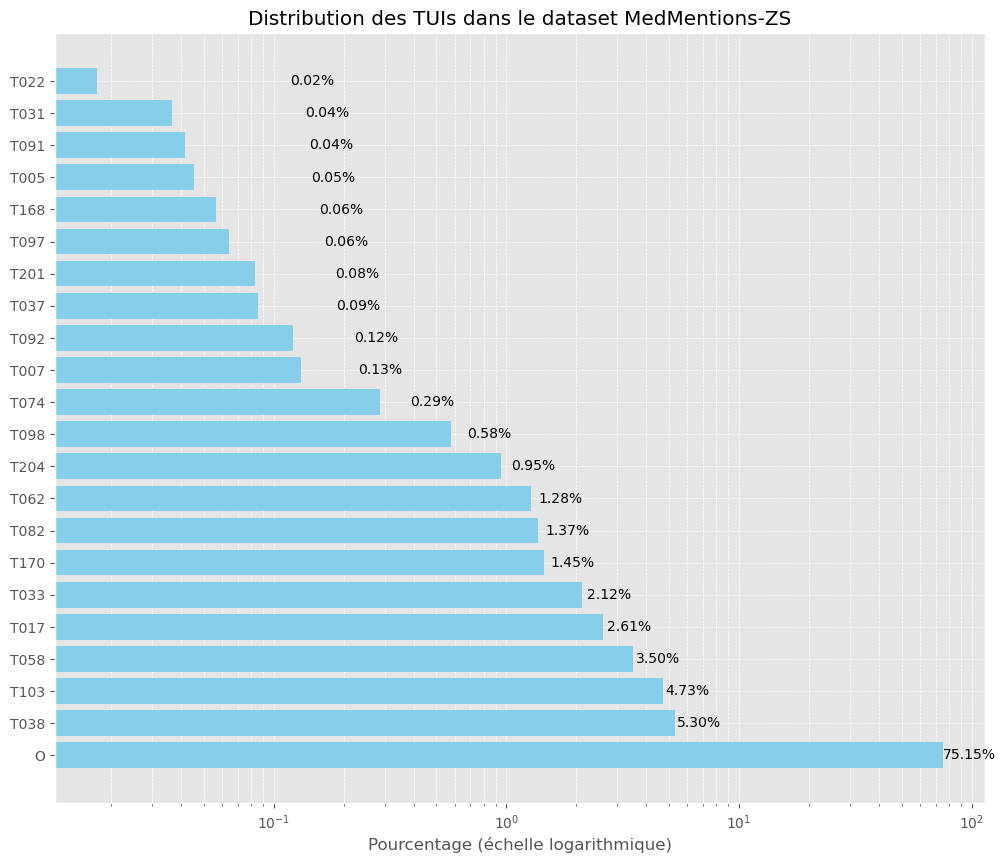

In [304]:
df_total_class.sort_values('Percentage', ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(12, 10))
ax.barh(df_total_class['TUI'], df_total_class['Percentage'], color='skyblue')
ax.set_xscale('log')
ax.set_xlabel('Pourcentage (échelle logarithmique)')
ax.set_title('Distribution des TUIs dans le dataset MedMentions-ZS')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
# Ajout des labels 
for i, v in enumerate(df_total_class['Percentage']):
    ax.text(v + 0.1, i, f"{v:.2f}%", color='black', va='center')

plt.show()





# Analyse de la longueur des textes 

In [305]:
from datasets import load_dataset
from datasets import concatenate_datasets

dataset = load_dataset('ibm-research/MedMentions-ZS', trust_remote_code=True)
combined = concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])

new_dataset = balanced_split(
    dataset,
    seed=42
)
train_dataset, val_dataset, test_dataset = new_dataset['train'], new_dataset['validation'], new_dataset['test']
new_combined = concatenate_datasets([train_dataset, val_dataset, test_dataset])

Extraction des NER-Tags...
Fait!
Création du mapping TUI vers indice...
Fait!
Shuffle des indices avant le split...
Fait!
Création du premier split (train VS reste)...
Fait!
Création du deuxième split (val VS test)...
Fait!
Conversion des indices...
Fait! 
Tous les exemples sont dans un split! et sans overlaps.
Stratification terminée!


In [306]:
# convertir en DataFrame
import pandas as pd
df = pd.DataFrame(combined)
new_df = pd.DataFrame(new_combined)
df.head(), new_df.head()

(                                              tokens  \
 0  [DCTN4, as, a, modifier, of, chronic, Pseudomo...   
 1  [Pseudomonas, aeruginosa, (, Pa, ), infection,...   
 2  [By, using, exome, sequencing, and, extreme, p...   
 3  [The, purpose, of, this, study, was, to, inves...   
 4  [Polymerase, chain, reaction, and, direct, seq...   
 
                                             ner_tags  
 0  [B-T103, O, O, O, O, B-T038, I-T038, I-T038, I...  
 1  [B-T038, I-T038, I-T038, I-T038, I-T038, I-T03...  
 2  [O, O, B-T062, I-T062, O, O, O, O, O, O, O, O,...  
 3  [O, O, O, O, B-T062, O, O, O, O, O, O, B-T103,...  
 4  [B-T062, I-T062, I-T062, O, B-T062, I-T062, O,...  ,
                                               tokens  \
 0  [DCTN4, as, a, modifier, of, chronic, Pseudomo...   
 1  [Pseudomonas, aeruginosa, (, Pa, ), infection,...   
 2  [By, using, exome, sequencing, and, extreme, p...   
 3  [The, purpose, of, this, study, was, to, inves...   
 4  [Polymerase, chain, reaction, 

In [307]:
df['num_tokens'] = df['tokens'].apply(lambda x: len(x))
print(f"Seuil 95%: {df['num_tokens'].quantile(0.95)}")
print(f"Seuil 99%: {df['num_tokens'].quantile(0.99)}")
print(df.describe())


Seuil 95%: 51.0
Seuil 99%: 72.93999999999869
         num_tokens
count  29107.000000
mean      26.390559
std       13.433501
min        1.000000
25%       17.000000
50%       24.000000
75%       32.000000
max      179.000000


<AxesSubplot:title={'center':'Distribution du nombre de tokens par document'}, ylabel='Frequency'>

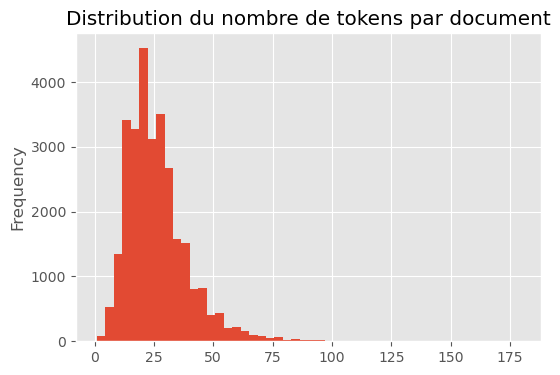

In [308]:

# Visualiser la distribution du nombre de tokens

df['num_tokens'].plot(kind='hist', bins=50, figsize=(6, 4), title='Distribution du nombre de tokens par document')


<AxesSubplot:title={'center':'Distribution du nombre de tokens par document (nouveau split)'}, ylabel='Frequency'>

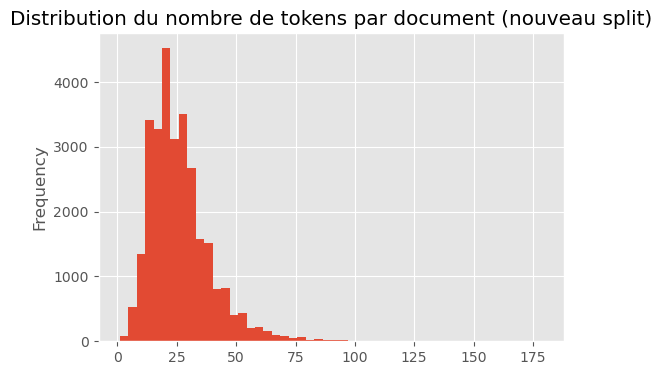

In [309]:
new_df['num_tokens'] = new_df['tokens'].apply(lambda x: len(x))

new_df['num_tokens'].plot(kind='hist', bins=50, figsize=(6, 4), title='Distribution du nombre de tokens par document (nouveau split)')

In [310]:
df_train, df_val, df_test = pd.DataFrame(train_dataset), pd.DataFrame(val_dataset), pd.DataFrame(test_dataset)
new_df_train, new_df_val, new_df_test = pd.DataFrame(new_dataset['train']), pd.DataFrame(new_dataset['validation']), pd.DataFrame(new_dataset['test'])

df_train['num_tokens'] = df_train['tokens'].apply(lambda x: len(x))
df_val['num_tokens'] = df_val['tokens'].apply(lambda x: len(x))
df_test['num_tokens'] = df_test['tokens'].apply(lambda x: len(x))

new_df_train['num_tokens'] = new_df_train['tokens'].apply(lambda x: len(x))
new_df_val['num_tokens'] = new_df_val['tokens'].apply(lambda x: len(x))
new_df_test['num_tokens'] = new_df_test['tokens'].apply(lambda x: len(x))   

# Visualiser la distribution du nombre de tokens pour chaque split

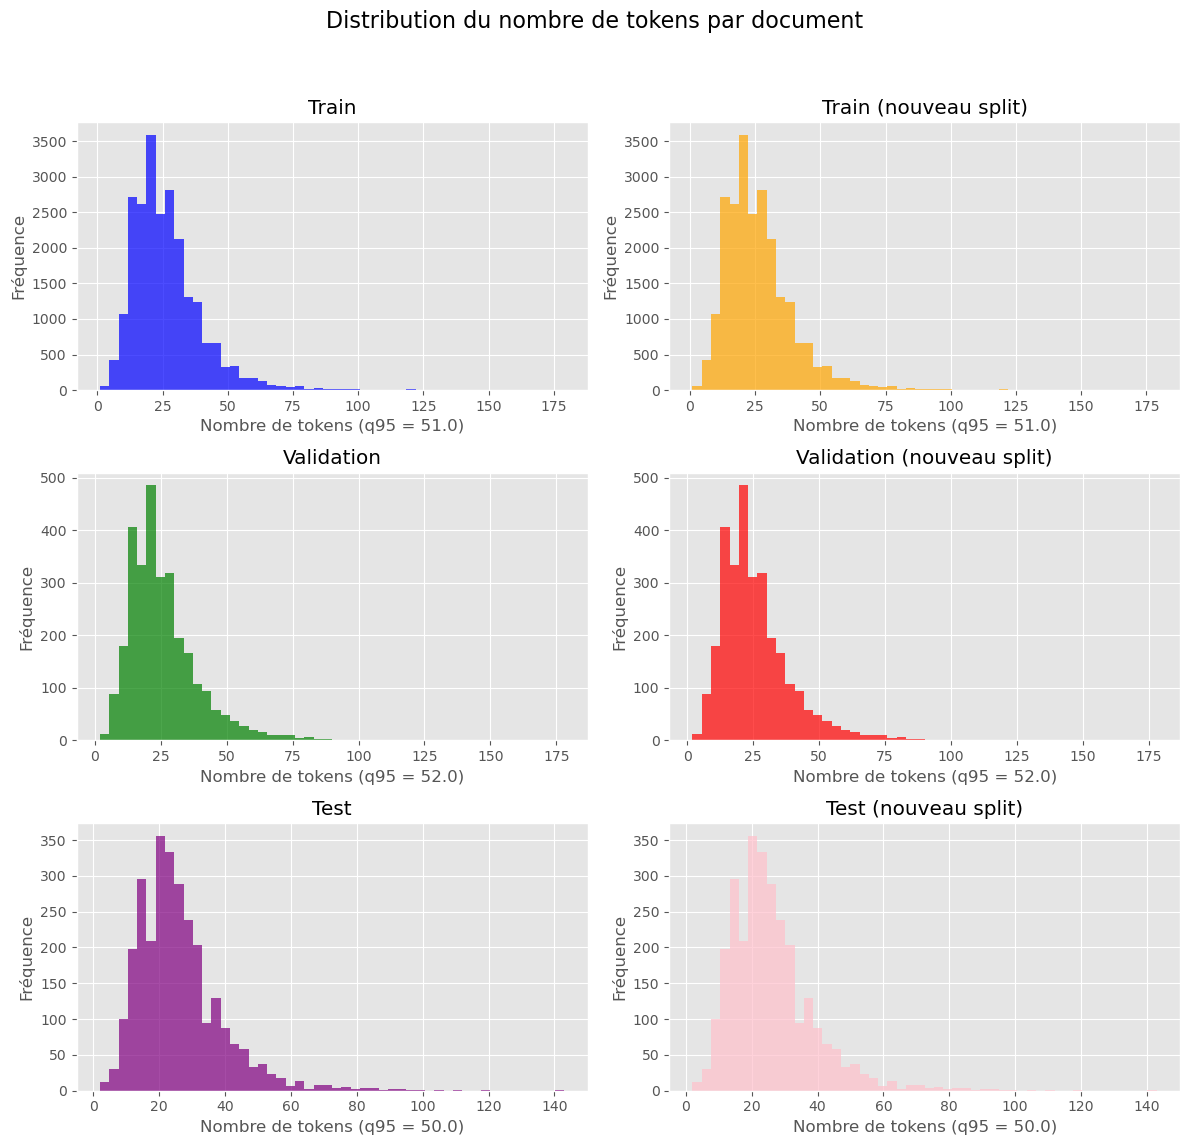

In [311]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Distribution du nombre de tokens par document', fontsize=16)

axes[0, 0].hist(df_train['num_tokens'], bins=50, color='blue', alpha=0.7)
axes[0, 0].set_title('Train')
axes[0, 0].set_xlabel(f'Nombre de tokens (q95 = {df_train["num_tokens"].quantile(0.95)})')
axes[0, 0].set_ylabel('Fréquence')

axes[0, 1].hist(new_df_train['num_tokens'], bins=50, color='orange', alpha=0.7)
axes[0, 1].set_title('Train (nouveau split)')
axes[0, 1].set_xlabel(f'Nombre de tokens (q95 = {new_df_train["num_tokens"].quantile(0.95)})')
axes[0, 1].set_ylabel('Fréquence')

axes[1, 0].hist(df_val['num_tokens'], bins=50, color='green', alpha=0.7)
axes[1, 0].set_title('Validation')
axes[1, 0].set_xlabel(f'Nombre de tokens (q95 = {df_val["num_tokens"].quantile(0.95)})')
axes[1, 0].set_ylabel('Fréquence')

axes[1, 1].hist(new_df_val['num_tokens'], bins=50, color='red', alpha=0.7)
axes[1, 1].set_title('Validation (nouveau split)')
axes[1, 1].set_xlabel(f'Nombre de tokens (q95 = {new_df_val["num_tokens"].quantile(0.95)})')
axes[1, 1].set_ylabel('Fréquence')

axes[2, 0].hist(df_test['num_tokens'], bins=50, color='purple', alpha=0.7)
axes[2, 0].set_title('Test')
axes[2, 0].set_xlabel(f'Nombre de tokens (q95 = {df_test["num_tokens"].quantile(0.95)})')
axes[2, 0].set_ylabel('Fréquence')

axes[2, 1].hist(new_df_test['num_tokens'], bins=50, color='pink', alpha=0.7)    
axes[2, 1].set_title('Test (nouveau split)')
axes[2, 1].set_xlabel(f'Nombre de tokens (q95 = {new_df_test["num_tokens"].quantile(0.95)})')
axes[2, 1].set_ylabel('Fréquence')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()





## Visualisation de l'équilibrage

In [312]:
from datasets import load_dataset
from datasets import concatenate_datasets

dataset = load_dataset('ibm-research/MedMentions-ZS', trust_remote_code=True)
train, val, test = dataset['train'], dataset['validation'], dataset['test']

new_dataset = balanced_split(
    dataset,
    seed=42
)
new_train, new_val, new_test = new_dataset['train'], new_dataset['validation'], new_dataset['test']


Extraction des NER-Tags...
Fait!
Création du mapping TUI vers indice...
Fait!
Shuffle des indices avant le split...
Fait!
Création du premier split (train VS reste)...
Fait!
Création du deuxième split (val VS test)...
Fait!
Conversion des indices...
Fait! 
Tous les exemples sont dans un split! et sans overlaps.
Stratification terminée!


In [313]:
train = pd.DataFrame(train)
val = pd.DataFrame(val)
test = pd.DataFrame(test)
new_train = pd.DataFrame(new_train)
new_val = pd.DataFrame(new_val)
new_test = pd.DataFrame(new_test)

In [314]:
# Conversion de BIO vers TUI 
def bio_to_tui(bio_tags, tui_list):
    """Convertit les tags BIO en TUIs"""
    tui_tags = []
    for tag in bio_tags:
        if tag.startswith('B-'):
            tui_tags.append(tag[2:])
        elif tag.startswith('I-'):
            tui_tags.append(tag[2:])
        else:
            tui_tags.append('O')
    return tui_tags

# Conversion des tags BIO en TUIs pour chaque split
train['tui_tags'] = train['ner_tags'].apply(lambda x: bio_to_tui(x, tui_list))
val['tui_tags'] = val['ner_tags'].apply(lambda x: bio_to_tui(x, tui_list))
test['tui_tags'] = test['ner_tags'].apply(lambda x: bio_to_tui(x, tui_list))
new_train['tui_tags'] = new_train['ner_tags'].apply(lambda x: bio_to_tui(x, tui_list))
new_val['tui_tags'] = new_val['ner_tags'].apply(lambda x: bio_to_tui(x, tui_list))
new_test['tui_tags'] = new_test['ner_tags'].apply(lambda x: bio_to_tui(x, tui_list))

print(new_train.head())

                                              tokens  \
0  [DCTN4, as, a, modifier, of, chronic, Pseudomo...   
1  [Pseudomonas, aeruginosa, (, Pa, ), infection,...   
2  [By, using, exome, sequencing, and, extreme, p...   
3  [The, purpose, of, this, study, was, to, inves...   
4  [Polymerase, chain, reaction, and, direct, seq...   

                                            ner_tags  \
0  [B-T103, O, O, O, O, B-T038, I-T038, I-T038, I...   
1  [B-T038, I-T038, I-T038, I-T038, I-T038, I-T03...   
2  [O, O, B-T062, I-T062, O, O, O, O, O, O, O, O,...   
3  [O, O, O, O, B-T062, O, O, O, O, O, O, B-T103,...   
4  [B-T062, I-T062, I-T062, O, B-T062, I-T062, O,...   

                                            tui_tags  
0  [T103, O, O, O, O, T038, T038, T038, T038, O, ...  
1  [T038, T038, T038, T038, T038, T038, O, T038, ...  
2  [O, O, T062, T062, O, O, O, O, O, O, O, O, O, ...  
3  [O, O, O, O, T062, O, O, O, O, O, O, T103, O, ...  
4  [T062, T062, T062, O, T062, T062, O, O, O, O, ..

In [315]:
# Calculer la distribution des TUIs pour chaque split
def get_tui_distribution(df):
    """Calculer la distribution des TUIs dans le dataset"""
    tui_counter = Counter()
    for tui_tags in df['ner_tags']:
        tui_counter.update(tui_tags)
    return tui_counter

# Calculer les distributions
train_dist = get_tui_distribution(train)
val_dist = get_tui_distribution(val)
test_dist = get_tui_distribution(test)
new_train_dist = get_tui_distribution(new_train)
new_val_dist = get_tui_distribution(new_val)
new_test_dist = get_tui_distribution(new_test)

# Trier les distributions
train_dist = dict(sorted(train_dist.items(), key=lambda item: item[1], reverse=True))
val_dist = dict(sorted(val_dist.items(), key=lambda item: item[1], reverse=True))
test_dist = dict(sorted(test_dist.items(), key=lambda item: item[1], reverse=True))
new_train_dist = dict(sorted(new_train_dist.items(), key=lambda item: item[1], reverse=True))
new_val_dist = dict(sorted(new_val_dist.items(), key=lambda item: item[1], reverse=True))
new_test_dist = dict(sorted(new_test_dist.items(), key=lambda item: item[1], reverse=True))

In [316]:
train_count_df = pd.DataFrame(list(train_dist.items()), columns=['TUI', 'CountTrain'])
val_count_df = pd.DataFrame(list(val_dist.items()), columns=['TUI', 'CountVal'])
test_count_df = pd.DataFrame(list(test_dist.items()), columns=['TUI', 'CountTest'])
new_train_count_df = pd.DataFrame(list(new_train_dist.items()), columns=['TUI', 'CountNewTrain'])
new_val_count_df = pd.DataFrame(list(new_val_dist.items()), columns=['TUI', 'CountNewVal'])
new_test_count_df = pd.DataFrame(list(new_test_dist.items()), columns=['TUI', 'CountNewTest'])

# Fusionner les DataFrames
merged_count_df = pd.merge(train_count_df, val_count_df, on='TUI', how='outer')
merged_count_df = pd.merge(merged_count_df, test_count_df, on='TUI', how='outer')
merged_count_df = pd.merge(merged_count_df, new_train_count_df, on='TUI', how='outer')
merged_count_df = pd.merge(merged_count_df, new_val_count_df, on='TUI', how='outer')
merged_count_df = pd.merge(merged_count_df, new_test_count_df, on='TUI', how='outer')
merged_count_df = merged_count_df.fillna(0)  # Remplacer les NaN par 0

# Ajouter une colonne pour le pourcentage
merged_count_df['Total'] = merged_count_df[['CountTrain', 'CountVal', 'CountTest']].sum(axis=1)
merged_count_df['PercentageTrain'] = (merged_count_df['CountTrain'] / merged_count_df['Total']) * 100
merged_count_df['PercentageVal'] = (merged_count_df['CountVal'] / merged_count_df['Total']) * 100
merged_count_df['PercentageTest'] = (merged_count_df['CountTest'] / merged_count_df['Total']) * 100
merged_count_df['PercentageNewTrain'] = (merged_count_df['CountNewTrain'] / merged_count_df['Total']) * 100
merged_count_df['PercentageNewVal'] = (merged_count_df['CountNewVal'] / merged_count_df['Total']) * 100
merged_count_df['PercentageNewTest'] = (merged_count_df['CountNewTest'] / merged_count_df['Total']) * 100

merged_count_df['ProportionTrain'] = merged_count_df['CountTrain'] / merged_count_df['CountTrain'].sum()
merged_count_df['ProportionVal'] = merged_count_df['CountVal'] / merged_count_df['CountVal'].sum()
merged_count_df['ProportionTest'] = merged_count_df['CountTest'] / merged_count_df['CountTest'].sum()
merged_count_df['ProportionNewTrain'] = merged_count_df['CountNewTrain'] / merged_count_df['CountNewTrain'].sum()
merged_count_df['ProportionNewVal'] = merged_count_df['CountNewVal'] / merged_count_df['CountNewVal'].sum()
merged_count_df['ProportionNewTest'] = merged_count_df['CountNewTest'] / merged_count_df['CountNewTest'].sum()


merged_count_df = merged_count_df.fillna(0)  # Remplacer les NaN par 0

In [317]:
print(merged_count_df.head(10))

      TUI  CountTrain  CountVal  CountTest  CountNewTrain  CountNewVal  \
0       O    515420.0   34400.0    27433.0         463032        57856   
1  B-T038     25007.0       0.0        0.0          19938         2562   
2  B-T103     22360.0       0.0        0.0          17991         2177   
3  I-T038     15708.0       0.0        0.0          12603         1596   
4  B-T058     14779.0       0.0        0.0          11832         1481   
5  I-T103     14011.0       0.0        0.0          11201         1426   
6  B-T017     12575.0       0.0        0.0          10072         1233   
7  I-T058     12088.0       0.0        0.0           9616         1182   
8  B-T033      9824.0       0.0        0.0           7860          990   
9  B-T082      7511.0       0.0        0.0           6018          741   

   CountNewTest     Total  PercentageTrain  PercentageVal  PercentageTest  \
0         56365  577253.0        89.288406       5.959259        4.752336   
1          2507   25007.0      

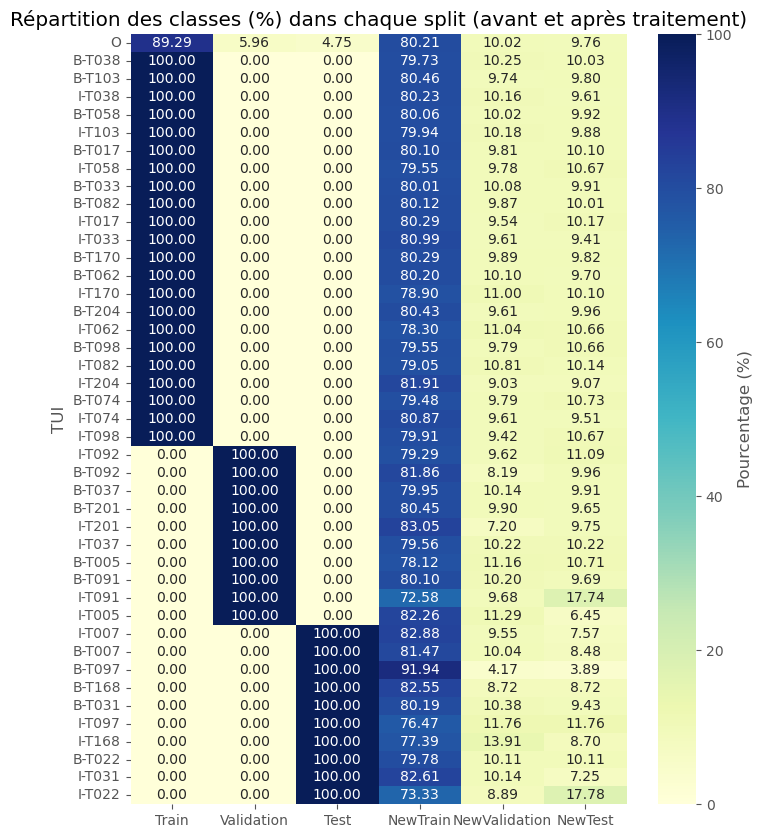

In [318]:
import seaborn as sns

# Sélection des colonnes pertinentes
cols = ['PercentageTrain', 'PercentageVal', 'PercentageTest', 
        'PercentageNewTrain', 'PercentageNewVal', 'PercentageNewTest']
labels = ['Train', 'Validation', 'Test',
          'NewTrain', 'NewValidation', 'NewTest']

heatmap_data = merged_count_df.set_index('TUI')[cols]
heatmap_data.columns = labels

plt.figure(figsize=(8, 10))
sns.heatmap(heatmap_data, annot=True, fmt=".2f",  cbar_kws={'label': 'Pourcentage (%)'}, cmap='YlGnBu')
plt.title("Répartition des classes (%) dans chaque split (avant et après traitement)")
plt.show()


In [319]:
merged_count_df[['TUI', 'PercentageTrain', 'PercentageVal', 'PercentageTest', 
                   'PercentageNewTrain', 'PercentageNewVal', 'PercentageNewTest', 'Total']]

,TUI,PercentageTrain,PercentageVal,PercentageTest,PercentageNewTrain,PercentageNewVal,PercentageNewTest,Total
0,O,89.288406,5.959259,4.752336,80.213009,10.022642,9.764349,577253.0
1,B-T038,100.000000,0.000000,0.000000,79.729676,10.245131,10.025193,25007.0
2,B-T103,100.000000,0.000000,0.000000,80.460644,9.736136,9.803220,22360.0
3,I-T038,100.000000,0.000000,0.000000,80.233002,10.160428,9.606570,15708.0
4,B-T058,100.000000,0.000000,0.000000,80.059544,10.020976,9.919480,14779.0
5,I-T103,100.000000,0.000000,0.000000,79.944329,10.177718,9.877953,14011.0
6,B-T017,100.000000,0.000000,0.000000,80.095427,9.805169,10.099404,12575.0
7,I-T058,100.000000,0.000000,0.000000,79.549967,9.778293,10.671741,12088.0
8,B-T033,100.000000,0.000000,0.000000,80.008143,10.077362,9.914495,9824.0
9,B-T082,100.000000,0.000000,0.000000,80.122487,9.865531,10.011982,7511.0


<AxesSubplot:>

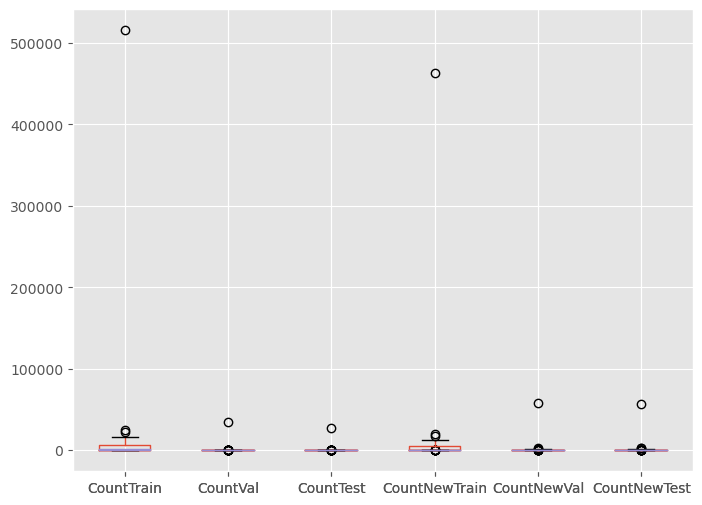

In [320]:
merged_count_df.boxplot(column=['PercentageTrain', 'PercentageVal', 'PercentageTest',
                               'PercentageNewTrain', 'PercentageNewVal', 'PercentageNewTest'], figsize=(8, 6))
merged_count_df.boxplot(column=['CountTrain', 'CountVal', 'CountTest',
                               'CountNewTrain', 'CountNewVal', 'CountNewTest'], figsize=(8, 6))


In [321]:
merged_count_df[['CountTrain', 'CountVal', 'CountTest',
                   'CountNewTrain', 'CountNewVal', 'CountNewTest', 'Total']].sum(axis=0).astype(int)

CountTrain       701070
CountVal          37297
CountTest         29783
CountNewTrain    615864
CountNewVal       76915
CountNewTest      75371
Total            768150
dtype: int32

# Données adjudiquées - Comparaison des classes 

In [322]:
import json 
root_data = 'etape2/data/'

# Charger les fichiers jsons 
data1 = json.load(open(root_data + 'curated_data_team1.json'))
data2 = json.load(open(root_data + 'curated_data_team2.json'))
data3 = json.load(open(root_data + 'curated_data_team3.json'))
data4 = json.load(open(root_data + 'curated_data_team4.json'))
data6 = json.load(open(root_data + 'curated_data_team6.json'))




In [323]:
# fusionner les données 
data = data1 + data2 + data3 + data4 + data6


In [324]:
# distribution des TUIs dans les données
tui_counter = Counter()
for example in data:
    tui_counter.update(example['ner_tags'])
# Trier les distributions
tui_counter = dict(sorted(tui_counter.items(), key=lambda item: item[1], reverse=True))

# Créer un DataFrame pour la visualisation
tui_df = pd.DataFrame(list(tui_counter.items()), columns=['TUI', 'Count'])


In [325]:
# print(tui_df.head(10))
# print(merged_df[["TUI", "Total"]].head(10))

# Fusionner les DataFrames
df_curated_merged = pd.merge(tui_df, merged_df[["TUI", "Total"]], on='TUI', how='outer')

# Rename columns
df_curated_merged.rename(columns={"Count": "CountCurated", "Total": "CountOriginal"}, inplace=True)
df_curated_merged.fillna(0, inplace=True)

df_curated_merged['CountCurated'] = df_curated_merged['CountCurated'].astype(int)
df_curated_merged['CountOriginal'] = df_curated_merged['CountOriginal'].astype(int)

df_curated_merged['PercentageCurated'] = (df_curated_merged['CountCurated'] / df_curated_merged['CountCurated'].sum()) * 100
df_curated_merged['PercentageOriginal'] = (df_curated_merged['CountOriginal'] / df_curated_merged['CountOriginal'].sum()) * 100
df_curated_merged.head()

,TUI,CountCurated,CountOriginal,PercentageCurated,PercentageOriginal
0,O,31867,577253,92.547847,75.148474
1,B-T047,334,0,0.970000,0.000000
2,I-T047,287,0,0.833503,0.000000
3,B-T028,181,0,0.525659,0.000000
4,B-T191,181,0,0.525659,0.000000


In [326]:
TUI_not_in_medmention = df_curated_merged[df_curated_merged['CountOriginal'] == 0]['TUI'].to_list()

print(f"Nombre de TUIs absents dans MedMentions: {len(TUI_not_in_medmention)}")
print(f"Liste des TUIs absents dans MedMentions: {TUI_not_in_medmention}")

Nombre de TUIs absents dans MedMentions: 63
Liste des TUIs absents dans MedMentions: ['B-T047', 'I-T047', 'B-T028', 'B-T191', 'I-T191', 'B-T116', 'B-T023', 'I-T116', 'B-T025', 'I-T028', 'B-T109', 'B-T048', 'I-T048', 'B-T046', 'I-T025', 'IGN', 'I-T023', 'I-T046', 'I-T114', 'I-T109', 'B-T114', 'B-T045', 'I-T044', 'B-T044', 'I-T020', 'I-T184', 'B-T121', 'I-T063', 'B-T190', 'B-T184', 'I-T045', 'B-T020', 'I-T190', 'I-T059', 'I-T024', 'B-T024', 'B-T196', 'B-T104', 'B-T026', 'I-T121', 'B-T123', 'I-T041', 'B-T039', 'I-T039', 'B-T167', 'I-T167', 'B-T043', 'I-T043', 'B-T040', 'I-T019', 'I-T129', 'I-T026', 'B-T059', 'B-T125', 'I-T125', 'B-T041', 'B-T070', 'I-T070', 'B-T080', 'B-T019', 'B-T169', 'B-T129', 'B-T063']


In [327]:
TUI_in_medmention = df_curated_merged[df_curated_merged['CountOriginal'] > 0]['TUI'].to_list()
print(f"Nombre de TUIs présents dans MedMentions : {len(TUI_in_medmention)}")
print(f"Liste des TUIs présents dans MedMentions : {TUI_in_medmention}")

Nombre de TUIs présents dans MedMentions : 43
Liste des TUIs présents dans MedMentions : ['O', 'B-T005', 'B-T037', 'I-T037', 'I-T005', 'I-T033', 'B-T033', 'I-T007', 'B-T007', 'B-T031', 'B-T074', 'B-T038', 'I-T038', 'B-T103', 'B-T058', 'I-T103', 'B-T017', 'I-T058', 'B-T082', 'I-T017', 'B-T170', 'B-T062', 'I-T170', 'B-T204', 'I-T062', 'B-T098', 'I-T082', 'I-T204', 'I-T074', 'I-T098', 'I-T092', 'B-T092', 'B-T097', 'B-T201', 'B-T168', 'I-T201', 'B-T091', 'I-T097', 'I-T091', 'I-T168', 'B-T022', 'I-T031', 'I-T022']


In [328]:
df_curated_merged[df_curated_merged['CountOriginal'] > 0][df_curated_merged['CountOriginal'] < 1000]

C:\Users\nicos\AppData\Local\Temp\ipykernel_24516\2016337708.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_curated_merged[df_curated_merged['CountOriginal'] > 0][df_curated_merged['CountOriginal'] < 1000]


,TUI,CountCurated,CountOriginal,PercentageCurated,PercentageOriginal
19,B-T005,32,224,0.092934,0.029161
20,B-T037,28,434,0.081317,0.056499
21,I-T037,27,225,0.078413,0.029291
22,I-T005,22,124,0.063892,0.016143
34,I-T007,10,555,0.029042,0.072252
37,B-T007,8,448,0.023234,0.058322
53,B-T031,2,212,0.005808,0.027599
92,I-T098,0,881,0.000000,0.114691
93,I-T092,0,478,0.000000,0.062227
94,B-T092,0,452,0.000000,0.058843


In [329]:
df_curated_both = df_curated_merged[df_curated_merged['CountOriginal'] > 0][df_curated_merged['CountCurated'] > 0]
df_curated_both

C:\Users\nicos\AppData\Local\Temp\ipykernel_24516\3336381149.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_curated_both = df_curated_merged[df_curated_merged['CountOriginal'] > 0][df_curated_merged['CountCurated'] > 0]


,TUI,CountCurated,CountOriginal,PercentageCurated,PercentageOriginal
0,O,31867,577253,92.547847,75.148474
19,B-T005,32,224,0.092934,0.029161
20,B-T037,28,434,0.081317,0.056499
21,I-T037,27,225,0.078413,0.029291
22,I-T005,22,124,0.063892,0.016143
24,I-T033,19,6432,0.055180,0.837336
31,B-T033,13,9824,0.037754,1.278917
34,I-T007,10,555,0.029042,0.072252
37,B-T007,8,448,0.023234,0.058322
53,B-T031,2,212,0.005808,0.027599


In [330]:

df_curated_both = df_curated_both[df_curated_both['TUI'] != 'O']
df_curated_both['PercentageCurated'] = df_curated_both['CountCurated'] / df_curated_both['CountCurated'].sum() * 100
df_curated_both['PercentageOriginal'] = df_curated_both['CountOriginal'] / df_curated_both['CountOriginal'].sum() * 100

df_curated_both

C:\Users\nicos\AppData\Local\Temp\ipykernel_24516\521166849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curated_both['PercentageCurated'] = df_curated_both['CountCurated'] / df_curated_both['CountCurated'].sum() * 100
C:\Users\nicos\AppData\Local\Temp\ipykernel_24516\521166849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curated_both['PercentageOriginal'] = df_curated_both['CountOriginal'] / df_curated_both['CountOriginal'].sum() * 100


,TUI,CountCurated,CountOriginal,PercentageCurated,PercentageOriginal
19,B-T005,32,224,19.512195,0.371119
20,B-T037,28,434,17.073171,0.719043
21,I-T037,27,225,16.463415,0.372776
22,I-T005,22,124,13.414634,0.205441
24,I-T033,19,6432,11.585366,10.656417
31,B-T033,13,9824,7.926829,16.276219
34,I-T007,10,555,6.097561,0.919514
37,B-T007,8,448,4.878049,0.742238
53,B-T031,2,212,1.219512,0.351238
63,B-T074,1,1165,0.609756,1.930150


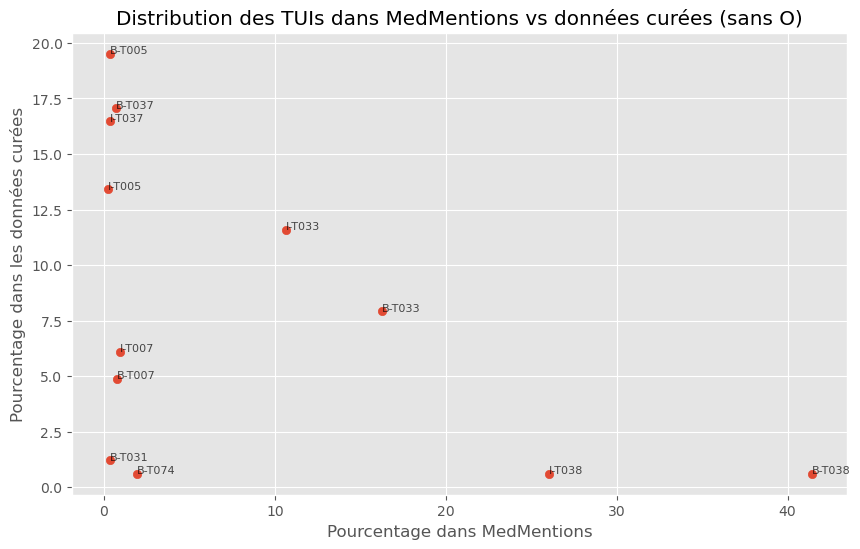

In [331]:
# Scatterplot 

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_curated_both['PercentageOriginal'], df_curated_both['PercentageCurated'])
ax.set_xlabel('Pourcentage dans MedMentions')
ax.set_ylabel('Pourcentage dans les données curées')
ax.set_title('Distribution des TUIs dans MedMentions vs données curées (sans O)')
plt.grid(True)

# textes 
for i, row in df_curated_both.iterrows():
    ax.annotate(row['TUI'], (row['PercentageOriginal'], row['PercentageCurated']), fontsize=8, alpha=0.7)
plt.show()

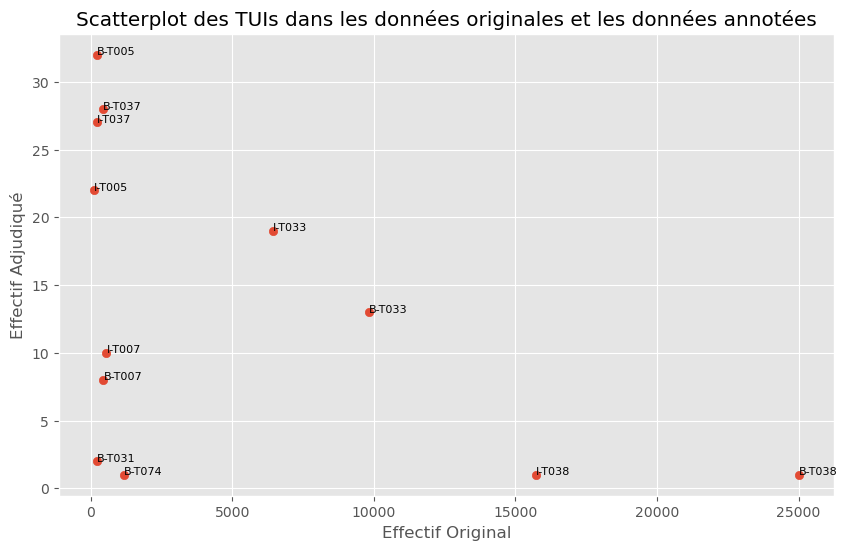

In [350]:


fig, ax = plt.subplots( 1, figsize=(10, 6))
ax.scatter(df_curated_both['CountOriginal'], df_curated_both['CountCurated'])

# Ajouter les labels
for i, txt in enumerate(df_curated_both['TUI']):
    ax.annotate(txt, (df_curated_both['CountOriginal'].iloc[i], df_curated_both['CountCurated'].iloc[i]), fontsize=8)
ax.set_xlabel('Effectif Original')
ax.set_ylabel('Effectif Adjudiqué')
ax.set_title('Scatterplot des TUIs dans les données originales et les données annotées')
plt.show()

# Analyse coo-occurence

In [333]:
from datasets import load_dataset
from datasets import concatenate_datasets

dataset = load_dataset('ibm-research/MedMentions-ZS', trust_remote_code=True)
train, val, test = dataset['train'], dataset['validation'], dataset['test']
merged_dataset = concatenate_datasets([train, val, test])


In [334]:
df = pd.DataFrame(merged_dataset)
df['tui_tags'] = df['ner_tags'].apply(lambda x: bio_to_tui(x, tui_list))
df

,tokens,ner_tags,tui_tags
0,"[DCTN4, as, a, modifier, of, chronic, Pseudomo...","[B-T103, O, O, O, O, B-T038, I-T038, I-T038, I...","[T103, O, O, O, O, T038, T038, T038, T038, O, ..."
1,"[Pseudomonas, aeruginosa, (, Pa, ), infection,...","[B-T038, I-T038, I-T038, I-T038, I-T038, I-T03...","[T038, T038, T038, T038, T038, T038, O, T038, ..."
2,"[By, using, exome, sequencing, and, extreme, p...","[O, O, B-T062, I-T062, O, O, O, O, O, O, O, O,...","[O, O, T062, T062, O, O, O, O, O, O, O, O, O, ..."
3,"[The, purpose, of, this, study, was, to, inves...","[O, O, O, O, B-T062, O, O, O, O, O, O, B-T103,...","[O, O, O, O, T062, O, O, O, O, O, O, T103, O, ..."
4,"[Polymerase, chain, reaction, and, direct, seq...","[B-T062, I-T062, I-T062, O, B-T062, I-T062, O,...","[T062, T062, T062, O, T062, T062, O, O, O, O, ..."
...,...,...,...
29102,"[FLASHE, surveys, were, developed, from, a, pr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, T09..."
29103,"[FLASHE, data, are, publicly, available, for, ...","[O, O, O, O, O, O, B-T097, O, B-T097, O, O, O,...","[O, O, O, O, O, O, T097, O, T097, O, O, O, O, ..."
29104,"[To, understand, the, origins, of, confidence,...","[O, O, O, O, O, O, O, O, B-T097, O, O, O, O, O...","[O, O, O, O, O, O, O, O, T097, O, O, O, O, O, O]"
29105,"[The, patient, is, the, center, of, the, medic...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, T09..."


In [335]:
import itertools
from collections import Counter

cooccurrence_per_instance = []

for row in df['tui_tags']:
    classes = set(tag for tag in row if tag != 'O')
    pairs = list(itertools.combinations(sorted(classes), 2))
    cooccurrence_per_instance.extend(pairs)

co_counts = Counter(cooccurrence_per_instance)

# Voir les cooccurrences les plus fréquentes
import pandas as pd
co_df = pd.DataFrame(co_counts.items(), columns=["TUI_pair", "Count"]).sort_values("Count", ascending=False)
print(co_df.head())


        TUI_pair  Count
0   (T038, T103)   5464
9   (T017, T038)   4442
21  (T038, T058)   4404
1   (T033, T038)   3835
8   (T017, T103)   3079


In [336]:
co_df.sort_values('Count', ascending=False, inplace=True)
co_df.head(20)

,TUI_pair,Count
0,"(T038, T103)",5464
9,"(T017, T038)",4442
21,"(T038, T058)",4404
1,"(T033, T038)",3835
8,"(T017, T103)",3079
36,"(T058, T103)",2848
11,"(T033, T058)",2474
20,"(T038, T082)",2398
2,"(T038, T062)",2166
37,"(T017, T058)",2137


In [337]:
token_tui = []

for tokens, tuis in zip(df['tokens'], df['tui_tags']):
    token_tui.extend([(tok, tui) for tok, tui in zip(tokens, tuis) if tui != 'O'])


In [338]:
from collections import defaultdict

suffix_by_tui = defaultdict(list)

for token, tui in token_tui:
    if len(token) > 3:
        suffix_by_tui[tui].append(token[-3:].lower())  # dernier trigramme

# Suffixes les plus fréquents par TUI
for tui, suffixes in suffix_by_tui.items():
    common = Counter(suffixes).most_common(5)
    print(f"{tui} ➤ {common}")


T103 ➤ [('ine', 996), ('ase', 597), ('ide', 572), ('tor', 545), ('ein', 479)]
T038 ➤ [('ion', 5242), ('ing', 1422), ('sis', 1198), ('ons', 764), ('ity', 762)]
T033 ➤ [('ion', 814), ('ive', 551), ('ing', 525), ('ted', 388), ('ity', 318)]
T062 ➤ [('udy', 1448), ('sis', 583), ('ion', 477), ('ies', 453), ('ing', 319)]
T098 ➤ [('men', 390), ('nts', 385), ('ion', 255), ('ers', 205), ('oup', 197)]
T017 ➤ [('lls', 1072), ('nes', 474), ('ell', 461), ('lar', 335), ('ial', 319)]
T074 ➤ [('ter', 84), ('nts', 63), ('ice', 60), ('ing', 52), ('tem', 49)]
T082 ➤ [('ral', 423), ('ion', 377), ('nal', 249), ('lar', 196), ('tal', 180)]
T058 ➤ [('ion', 2722), ('ent', 1229), ('ing', 1220), ('ted', 750), ('apy', 627)]
T170 ➤ [('ion', 541), ('ies', 307), ('cal', 209), ('del', 200), ('ing', 189)]
T204 ➤ [('ice', 411), ('man', 347), ('ats', 191), ('nts', 123), ('als', 119)]
T201 ➤ [('ers', 52), ('ker', 46), ('ion', 23), ('ity', 22), ('ody', 15)]
T091 ➤ [('ogy', 43), ('ine', 38), ('ics', 22), ('ese', 14), ('cal'

In [339]:
suffix_tag = set()

for tui, tags in suffix_by_tui.items():
    suffix_tag.update(tags)


tuis = set()
for tui, tags in suffix_by_tui.items():
    tuis.add(tui)
suffix_tag, tuis

# Suffixes les plus fréquents par TUI


({'nth',
  'ost',
  'nbc',
  '027',
  'uel',
  'pin',
  'cns',
  'tah',
  'udy',
  'old',
  'bds',
  'hel',
  'ota',
  'd(s',
  'vax',
  'ady',
  'ph-',
  'ams',
  'mim',
  'ss3',
  'luo',
  'cci',
  'exy',
  'l-3',
  '137',
  'cs3',
  'psp',
  'opq',
  'awa',
  'ugh',
  'ema',
  'xp3',
  'ati',
  'dia',
  'nee',
  'say',
  'sod',
  'lfo',
  'ida',
  'oks',
  'dh7',
  'rvs',
  '3a3',
  'sem',
  'ths',
  '3l1',
  'n)1',
  'cus',
  'le2',
  't6a',
  'ur1',
  '0(-',
  'usa',
  'ege',
  '}-3',
  'nq1',
  'tia',
  'ôte',
  'sis',
  'lbc',
  'tto',
  'r(-',
  'bbb',
  'vep',
  'pob',
  'mls',
  '468',
  'vak',
  'dic',
  'zem',
  'mnf',
  'acr',
  'ots',
  'mta',
  'ply',
  'thc',
  'd24',
  'vcs',
  'n70',
  'avf',
  'pae',
  'can',
  'o(-',
  'rpr',
  'cf3',
  'ada',
  'ga7',
  '597',
  'l-1',
  '510',
  'ohs',
  'arγ',
  'e-9',
  'cdd',
  '/4a',
  'sas',
  'pcg',
  'age',
  'm(i',
  'e-5',
  'ype',
  'ulk',
  'pmn',
  'bn1',
  'ody',
  'erk',
  'c(8',
  'gai',
  'sic',
  'ool',
  'lth',
 

In [340]:
confusion = defaultdict(lambda: defaultdict(int))
for tui, suffix_list in suffix_by_tui.items():
    for suffix, count in Counter(suffix_list).items():
        confusion[tui][suffix] += count

suffix_df = pd.DataFrame(confusion).fillna(0).T.astype(int)
suffix_df = suffix_df.astype(int)

suffix_df['LineSum'] = suffix_df.sum(axis=0)
suffix_df.sort_values('LineSum', ascending=False, inplace=True)
suffix_df = suffix_df.drop(columns=['LineSum'])
best_suffixes = suffix_df.max(axis=0).sort_values(ascending=False).head(5).index
suffix_df = suffix_df.loc[:, best_suffixes]
suffix_df = suffix_df.astype(int)

suffix_df.head()

,ion,udy,ing,ent,sis
T103,242,0,298,206,28
T038,5242,0,1422,431,1198
T033,814,0,525,233,258
T062,477,1448,319,126,583
T098,255,15,18,38,0


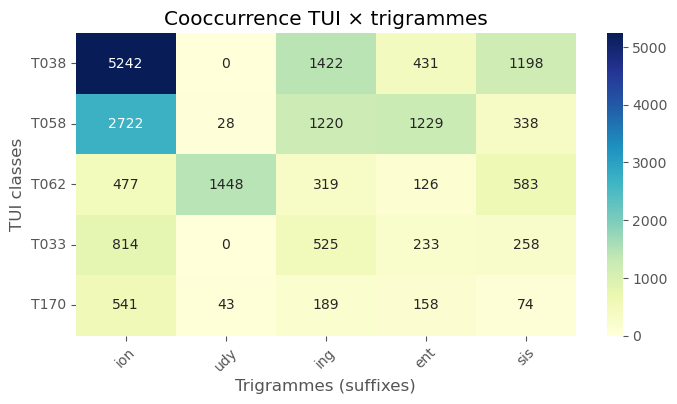

In [341]:
suffix_df['LineSum'] = suffix_df.sum(axis=1)
suffix_df.sort_values('LineSum', ascending=False, inplace=True)
suffix_df = suffix_df.drop(columns='LineSum')


# Affichage du heatmap
plt.figure(figsize=(7,4))
sns.heatmap(suffix_df.head(5), annot=True, fmt='d', cmap="YlGnBu")
plt.title("Cooccurrence TUI × trigrammes")
plt.xlabel("Trigrammes (suffixes)")
plt.ylabel("TUI classes")
plt.tight_layout()
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [342]:
!pip install nltk

In [343]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nicos\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [344]:

from nltk import pos_tag, word_tokenize
from collections import defaultdict, Counter

pos_by_tui = defaultdict(list)

for tokens, tuis in zip(df['tokens'], df['tui_tags']):
    tagged = pos_tag(tokens)  # [('The', 'DT'), ('gene', 'NN'), ...]
    for (token, pos), tui in zip(tagged, tuis):
        if tui != 'O':
            pos_by_tui[tui].append(pos)


In [345]:
pos_tags = set()

for tui, tags in pos_by_tui.items():
    pos_tags.update(tags)


tuis = set()
for tui, tags in pos_by_tui.items():
    tuis.add(tui)
pos_tags, tuis

({'#',
  '$',
  "''",
  '(',
  ')',
  ',',
  '.',
  ':',
  'CC',
  'CD',
  'DT',
  'EX',
  'FW',
  'IN',
  'JJ',
  'JJR',
  'JJS',
  'LS',
  'MD',
  'NN',
  'NNP',
  'NNPS',
  'NNS',
  'POS',
  'PRP',
  'PRP$',
  'RB',
  'RBR',
  'RBS',
  'RP',
  'SYM',
  'TO',
  'UH',
  'VB',
  'VBD',
  'VBG',
  'VBN',
  'VBP',
  'VBZ',
  'WDT',
  'WP',
  'WRB'},
 {'T005',
  'T007',
  'T017',
  'T022',
  'T031',
  'T033',
  'T037',
  'T038',
  'T058',
  'T062',
  'T074',
  'T082',
  'T091',
  'T092',
  'T097',
  'T098',
  'T103',
  'T168',
  'T170',
  'T201',
  'T204'})

In [346]:

# Résumé : les POS les plus fréquents par classe
res = []
for tui, pos_list in pos_by_tui.items():
    # print(f"{tui} ➤ {Counter(pos_list)}")
    res.append((tui, Counter(pos_list)))


# Aggrégation pour extraire la liste des POS 
pos_agg = defaultdict(list)
for TUI_in_medmention, pos_list in pos_by_tui.items():
    for pos, count in Counter(pos_list).items():
        pos_agg[pos].append((tui, count))



In [347]:
# Confusion TUI vs POS 

confusion = defaultdict(lambda: defaultdict(int))
for tui, pos_list in pos_by_tui.items():
    for pos, count in Counter(pos_list).items():
        confusion[tui][pos] += count
confusion_df = pd.DataFrame(confusion).fillna(0).astype(int)
top_tags = confusion_df.sum(axis=1).sort_values(ascending=False).head(4).index.tolist()
confusion_df = confusion_df.loc[top_tags].T
confusion_df

,NN,NNP,JJ,NNS
T103,11180,11440,4312,3392
T038,19022,6774,7165,3099
T033,5818,1327,3464,2173
T062,4352,1145,1320,996
T098,1006,355,737,1986
T017,6581,4327,3651,3606
T074,834,472,343,279
T082,3072,2390,2547,1034
T058,11490,4573,3918,1783
T170,3574,2972,1164,1755


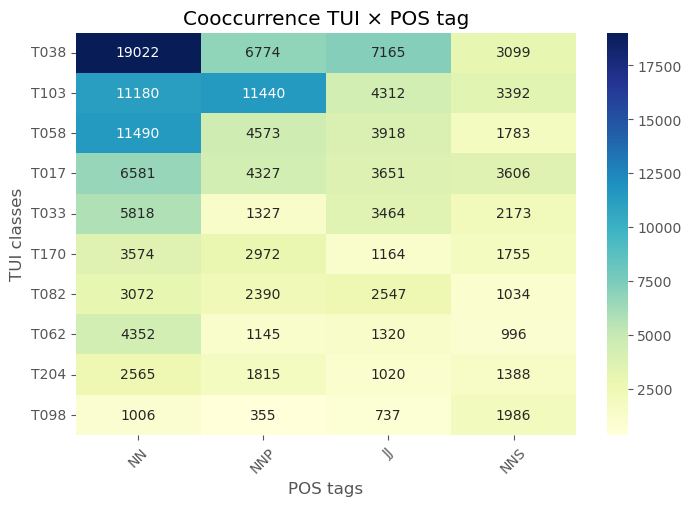

In [348]:
confusion_df['LineSum'] = confusion_df.sum(axis=1)
confusion_df.sort_values('LineSum', ascending=False, inplace=True)
confusion_df = confusion_df.drop(columns='LineSum')


# Affichage du heatmap
plt.figure(figsize=(7,5))
sns.heatmap(confusion_df.head(10), annot=True, fmt='d', cmap="YlGnBu")
plt.title("Cooccurrence TUI × POS tag")
plt.xlabel("POS tags")
plt.ylabel("TUI classes")
plt.tight_layout()
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()